# TensorFlow Hub 를 이용한 Transfer Learning

- Pre-trained Moblenet 사용

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications.mobilenet import decode_predictions

import numpy as np
import matplotlib.pyplot as plt

import time

## Flower Data download

In [2]:
flowers_data_path = tf.keras.utils.get_file(
  'flower_photos', 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', 
    untar=True, cache_dir='/content/')
print(flowers_data_path)

228827136/228813984 [==============================] - 2s 0us/step
/content/datasets/flower_photos


- ImageDataGenerator 생성 

In [3]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)

flowers_data = image_generator.flow_from_directory(
                    flowers_data_path, 
                    target_size=(224, 224), 
                    batch_size = 64, 
                    shuffle = True)

Found 3670 images belonging to 5 classes.


- flower data 는 5 개의 class 로 구성

In [4]:
input_batch, label_batch = next(flowers_data)

print("Image batch shape: ", input_batch.shape)
print("Label batch shape: ", label_batch.shape)
print("Label class 수: ", flowers_data.num_classes)
print("Class Index : ", flowers_data.class_indices)

Image batch shape:  (64, 224, 224, 3)
Label batch shape:  (64, 5)
Label class 수:  5
Class Index :  {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


class name 표시를 위해 class_names dictionary 생성

In [5]:
class_names = {v:k for k,v in flowers_data.class_indices.items()}
class_names

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

- 위에서 읽은 `input_batch` 중 10 개 image 시각화  
-  전처리된 image 를 reverse transform 하여 시각화

In [6]:
input_batch[0].min(), input_batch[0].max()

(-1.0, 1.0)

(-1.0, 1.0) 범위의 pixel 값을 (0, 255) 범위로 바꾸어 주기 위해 1 을 더해주고 127.5를 곱해준다.

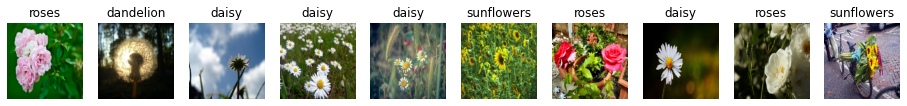

In [7]:
plt.figure(figsize=(16, 8))

for i in range(10):
    plt.subplot(1, 10, i+1)
    img = ((input_batch[i]+1)*127.5).astype(np.uint8)
    idx  = np.argmax(label_batch[i])
    plt.imshow(img)
    plt.title(class_names[idx])
    plt.axis('off')

## 전이학습 MODEL 을 특성 추출기로 사용하기 위해 head 가 제거된 model 을 download  

- https://tfhub.dev/s?module-type=image-feature-vector&q=tf2

In [8]:
extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

In [9]:
extractor_layer = hub.KerasLayer(extractor_url, input_shape=(224, 224, 3))

In [10]:
feature_batch = extractor_layer(input_batch)
print(feature_batch.shape)

(64, 1280)


- MobileNet 의 pre-trained weight 는 update 않음  

- Top layer 에 Dense layer 추가

In [11]:
extractor_layer.trainable = False

두 조각으로 모델 만들기  
(1) MobileNet 특징 추출기  
(2) 마지막에 Dense Network(classifier) ​​추가

In [12]:
model = tf.keras.Sequential([
    extractor_layer,
    tf.keras.layers.Dense(5, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
model.input, model.output

(<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'keras_layer_input')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'dense')>)

- output shape 이 정확한지 training 전에 사전 check

In [14]:
predictions = model(input_batch)

predictions.shape

TensorShape([64, 5])

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
s = time.time()

history = model.fit(flowers_data, epochs=30)

Epoch 1/30
58/58 [==============================] - 16s 219ms/step - loss: 0.9057 - accuracy: 0.6657
Epoch 2/30
58/58 [==============================] - 13s 220ms/step - loss: 0.4547 - accuracy: 0.8439
Epoch 3/30
58/58 [==============================] - 13s 219ms/step - loss: 0.3710 - accuracy: 0.8749
Epoch 4/30
58/58 [==============================] - 13s 220ms/step - loss: 0.3287 - accuracy: 0.8896
Epoch 5/30
58/58 [==============================] - 13s 218ms/step - loss: 0.2920 - accuracy: 0.9071
Epoch 6/30
58/58 [==============================] - 13s 220ms/step - loss: 0.2685 - accuracy: 0.9136
Epoch 7/30
58/58 [==============================] - 13s 219ms/step - loss: 0.2500 - accuracy: 0.9232
Epoch 8/30
58/58 [==============================] - 13s 220ms/step - loss: 0.2283 - accuracy: 0.9300
Epoch 9/30
58/58 [==============================] - 13s 221ms/step - loss: 0.2162 - accuracy: 0.9335
Epoch 10/30
58/58 [==============================] - 13s 219ms/step - loss: 0.2012 - accura

In [17]:
print("경과 시간 (분) :", (time.time() - s)/60)

경과 시간 (분) : 6.455652924378713


## Flower 분류 전문으로 Fine Tuning 된 MODEL 평가

In [18]:
y_pred = model.predict(input_batch)
y_pred = np.argmax(y_pred, axis=-1)
y_pred

array([2, 1, 0, 0, 0, 3, 2, 0, 2, 3, 4, 0, 4, 3, 3, 3, 0, 1, 4, 2, 0, 4,
       0, 1, 2, 3, 0, 3, 3, 1, 2, 1, 4, 2, 1, 0, 3, 0, 1, 1, 4, 4, 2, 1,
       4, 2, 4, 2, 2, 4, 0, 1, 1, 0, 1, 3, 1, 2, 1, 1, 3, 1, 4, 0])

In [19]:
y_true = np.argmax(label_batch, axis=-1)
y_true

array([2, 1, 0, 0, 0, 3, 2, 0, 2, 3, 4, 0, 4, 3, 3, 3, 0, 1, 4, 2, 0, 4,
       0, 1, 2, 3, 0, 3, 3, 1, 2, 1, 4, 2, 1, 0, 3, 0, 1, 1, 4, 4, 2, 1,
       4, 2, 4, 2, 4, 4, 3, 1, 1, 0, 1, 3, 1, 2, 1, 1, 3, 1, 4, 0])

In [20]:
f"{sum(y_pred == y_true) / len(y_true) * 100:.2f} %"

'96.88 %'

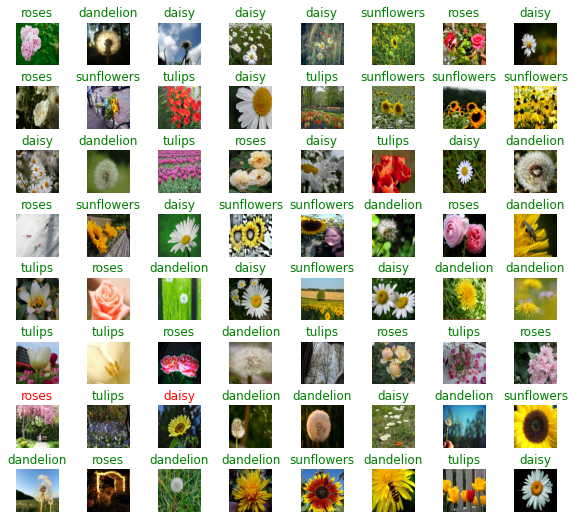

In [23]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for i in range(64):
  plt.subplot(8, 8, i+1)
  img = ((input_batch[i]+1)*127.5).astype(np.uint8)
  plt.imshow(img)
  color = "green" if y_pred[i] == y_true[i] else "red"
  plt.title(class_names[y_pred[i]], color=color)
  plt.axis('off')
